<a href="https://colab.research.google.com/github/aghapygad336/Fake-and-real-news/blob/master/digit_recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd 

import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler,ReduceLROnPlateau

from tensorflow import keras  
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.callbacks import LearningRateScheduler,ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPool2D, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
 from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
df_train = pd.read_csv('/content/drive/My Drive/ask/Character Recognition /digit-recognizer/train.csv')
df_test = pd.read_csv('/content/drive/My Drive/ask/Character Recognition /digit-recognizer/test.csv')

In [18]:
df_train.columns


Index(['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5',
       'pixel6', 'pixel7', 'pixel8',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=785)

In [19]:
X = df_train.iloc[:, 1:].values
y = df_train.iloc[:, 0].values

X.shape, y.shape, X.dtype, y.dtype


((42000, 784), (42000,), dtype('int64'), dtype('int64'))

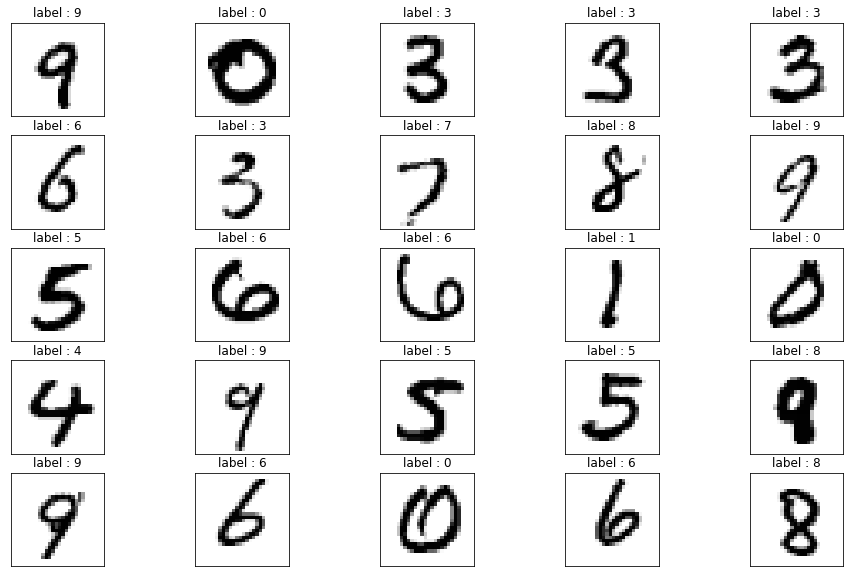

In [20]:
random_indexes = np.random.choice(range(len(X)), 25)

X_random = X[random_indexes]
y_random = y[random_indexes]


plt.figure(figsize = (16, 10))
for i in range(25):
    image = X_random[i]
    image = image.reshape((28, 28))
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image, "binary")
    plt.title('label : {}'.format(y_random[i]))
plt.show()


In [21]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)


In [22]:
X_test = df_test.values
X_test.shape
X_test_scaled = scaler.fit_transform(X_test)
X_test_scaled
X = X.reshape((42000, 28, 28, 1))
datagen = ImageDataGenerator(rotation_range=10,  zoom_range = 0.1,  width_shift_range=0.1,  height_shift_range=0.1)


In [23]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                                patience=3, 
                                verbose=1, 
                                factor=0.2, 
                                min_lr=1e-6)


In [24]:
# Creating 3 objects of the same CNN architecture and saving in model_list
model_list = []

for i in range(3):
    model = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size = 3, activation = 'relu', padding = 'same', input_shape = [28, 28, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, kernel_size = 3, activation = 'relu', padding = 'same'),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(32, kernel_size = 3, activation = 'relu', padding = 'same'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, kernel_size = 3, activation = 'relu', padding = 'same'),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(256, activation = 'relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation = 'softmax')])

    model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'nadam', metrics = ['accuracy'])
    model_list.append(model)


In [25]:
# Training all the 3 CNNs in the ensemble together

history = [0] * 3

for i in range(3):
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.03)
    history[i] = model_list[i].fit_generator(datagen.flow(X, y, batch_size = 128), 
                                             epochs = 20, validation_data = (X_valid, y_valid), callbacks = [reduce_lr])


Epoch 1/20
329/329 [==============================] - 191s 582ms/step - loss: 0.5180 - accuracy: 0.8415 - val_loss: 0.1740 - val_accuracy: 0.9587 - lr: 0.0010
Epoch 2/20
329/329 [==============================] - 192s 583ms/step - loss: 0.1632 - accuracy: 0.9516 - val_loss: 0.0479 - val_accuracy: 0.9817 - lr: 0.0010
Epoch 3/20
329/329 [==============================] - 192s 584ms/step - loss: 0.1142 - accuracy: 0.9661 - val_loss: 0.0402 - val_accuracy: 0.9857 - lr: 0.0010
Epoch 4/20
329/329 [==============================] - 192s 583ms/step - loss: 0.0938 - accuracy: 0.9718 - val_loss: 0.0363 - val_accuracy: 0.9889 - lr: 0.0010
Epoch 5/20
329/329 [==============================] - 192s 582ms/step - loss: 0.0791 - accuracy: 0.9768 - val_loss: 0.0396 - val_accuracy: 0.9849 - lr: 0.0010
Epoch 6/20
329/329 [==============================] - 192s 583ms/step - loss: 0.0727 - accuracy: 0.9792 - val_loss: 0.0331 - val_accuracy: 0.9889 - lr: 0.0010
Epoch 7/20
329/329 [==========================

In [26]:
ensemble_cnn_pred = np.zeros((X_test.shape[0], 10))
ensemble_cnn_pred.shape
X_test_scaled = X_test_scaled.reshape((28000, 28, 28, 1))


In [28]:
for i in range(3):
  ensemble_cnn_pred = ensemble_cnn_pred + model_list[i].predict(X_test_scaled)


In [29]:
np.sum(ensemble_cnn_pred[0])


6.000000006464247

In [30]:
pred_df_ensemble_cnn = pd.DataFrame(columns = ['ImageId', 'Label'])
pred_df_ensemble_cnn['ImageId'] = np.arange(1, 28001)
pred_df_ensemble_cnn['Label'] = ensemble_cnn_pred


In [31]:
pred_df_ensemble_cnn

,ImageId,Label
0,1,1.925940e-11
1,2,5.999991e+00
2,3,2.307667e-10
3,4,5.371760e+00
4,5,1.080729e-13
...,...,...
27995,27996,2.201680e-09
27996,27997,6.968404e-07
27997,27998,7.467857e-20
27998,27999,6.905308e-09
